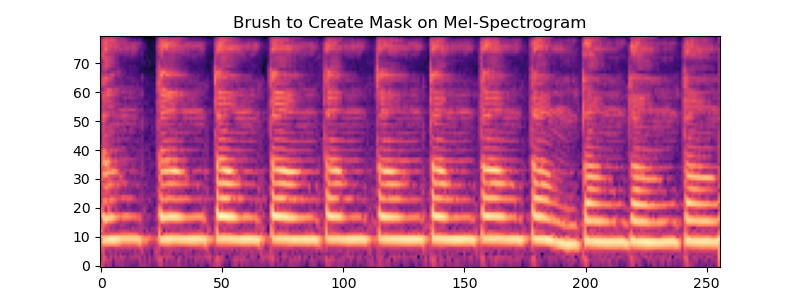

In [ ]:
%matplotlib widget

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from ipywidgets import Button, FloatSlider, IntSlider, ToggleButton, VBox, Text, HBox
from IPython.display import display
import torchaudio
import torch

def wav_to_mel(wav, window, stft_args, mel_filterbank):
    spec = torch.stft(wav, window=window, normalized=True, 
                    return_complex=True, **stft_args)
    magnitude = torch.abs(spec)
    mel_spec = mel_filterbank(magnitude)
    mel_spec = mel_spec / torch.max(mel_spec)
    return mel_spec

# Load audio and compute mel-spectrogram
audio_path = 'mix/real_1_mix.wav'
y, sr = librosa.load(audio_path, sr=16000)
mel_filterbank = torchaudio.transforms.MelScale(n_mels=80, sample_rate=sr, n_stft=256)
window = torch.hann_window(510, periodic=True)
stft_args = dict(n_fft=510, hop_length=256, center=True)
S = wav_to_mel(wav=torch.tensor(y),
                                  window=window,
                                  stft_args=stft_args,
                                  mel_filterbank=mel_filterbank)
S = S.squeeze().numpy()
S_dB = librosa.power_to_db(S, ref=np.max)

# Initialize mask
mask = np.zeros_like(S_dB)

duration = librosa.get_duration(y=y, sr=sr)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(S_dB, aspect='auto', origin='lower', cmap='magma')
plt.title('Brush to Create Mask on Mel-Spectrogram')

# Brush properties
brush_size = 8  # Default brush size
mask_value = 1.0  # Default mask value
eraser_mode = False  # Default mode is drawing

# Function to handle mouse motion
def on_motion(event):
    if event.inaxes is not None and event.button == 1:  # Check if left mouse button is pressed
        x, y = int(event.xdata), int(event.ydata)
        # Update the mask within the brush area
        for i in range(y - brush_size, y + brush_size + 1):
            for j in range(x - brush_size, x + brush_size + 1):
                if 0 <= i < S_dB.shape[0] and 0 <= j < S_dB.shape[1]:
                    if eraser_mode:
                        mask[i, j] = 0  # Erase (set mask value to 0)
                    else:
                        mask[i, j] = mask_value  # Draw (set mask value)
        # Update the plot
        if hasattr(on_motion, 'mask_image'):
            on_motion.mask_image.remove()
        on_motion.mask_image = ax.imshow(mask, cmap='Reds', alpha=0.4, origin='lower')  # Overlay mask
        fig.canvas.draw()

# Connect the motion event to the function
fig.canvas.mpl_connect('motion_notify_event', on_motion)

# Function to save the mask
def save_mask(b):
    np.save('masks/mask_real_1_mix_p.npy', mask)

# Function to update brush size
def update_brush_size(change):
    global brush_size
    brush_size = change.new

# Function to update mask value
def update_mask_value(change):
    global mask_value
    mask_value = change.new

# Function to toggle eraser mode
def toggle_eraser(change):
    global eraser_mode
    eraser_mode = change.new
    eraser_button.description = "Eraser: ON" if eraser_mode else "Eraser: OFF"

# Function to load a mask from the server
def load_mask(b):
    global mask
    mask_path = mask_path_text.value  # Get the path from the text input
    try:
        mask = np.load(mask_path)  # Load the mask from the server
        # Update the plot
        if hasattr(on_motion, 'mask_image'):
            on_motion.mask_image.remove()
        on_motion.mask_image = ax.imshow(mask, cmap='Reds', alpha=0.4, origin='lower')  # Overlay mask
        fig.canvas.draw()
        print(f"Mask loaded successfully from {mask_path}!")
    except Exception as e:
        print(f"Error loading mask: {e}")

# Create sliders for brush size and mask value
brush_size_slider = IntSlider(value=8, min=1, max=20, step=1, description='Brush Size:')
mask_value_slider = FloatSlider(value=1.0, min=0.0, max=1.0, step=0.1, description='Mask Value:')

# Create a toggle button for eraser mode
eraser_button = ToggleButton(value=False, description='Eraser: OFF')
eraser_button.observe(toggle_eraser, names='value')

# Create a text input for the mask path
mask_path_text = Text(placeholder='Enter path to mask file (e.g., masks/mask.npy)', description='Mask Path:')

# Create a button to load the mask
load_mask_button = Button(description="Load Mask")
load_mask_button.on_click(load_mask)

# Create a save button
save_button = Button(description="Save Mask")
save_button.on_click(save_mask)

# Attach slider updates to their respective functions
brush_size_slider.observe(update_brush_size, names='value')
mask_value_slider.observe(update_mask_value, names='value')

# Display sliders, eraser button, load mask input, and save button
display(VBox([
    brush_size_slider,
    mask_value_slider,
    eraser_button,
    HBox([mask_path_text, load_mask_button]),  # Text input and load button in a horizontal layout
    save_button
]))

plt.show()